In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout, Flatten, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras import applications
import os
import matplotlib.image as mpimg
import cv2

%matplotlib inline

Using TensorFlow backend.


In [2]:
path = 'C:/Users/Isaac/Documents/tensorflow/cat_dog/subset/'

loading training data:

In [36]:
class_names = ['cat', 'dog']

In [3]:
train_cat = os.listdir(path + 'train/cat/')
train_dog = os.listdir(path + 'train/dog/')

In [4]:
train = np.empty((2000,150,150,3))
for i,item in enumerate(train_cat):
    img = cv2.imread(path + 'train/cat/' + item)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(150,150))
    train[i,:,:,:] = img
for i, item in enumerate(train_dog):
    img = cv2.imread(path + 'train/dog/' + item)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(150,150))
    train[i+1000,:,:,:] = img

In [5]:
one = np.array([0,1]*1000)
zero = np.array([1,0]*1000)
train_labels = np.concatenate([zero.reshape((1000,2)), one.reshape((1000,2))])

loading validation data:

In [6]:
validation_cat = os.listdir(path + 'validation/cat/')
validation_dog = os.listdir(path + 'validation/dog/')

In [7]:
validation = np.empty((800,150,150,3))
for i,item in enumerate(validation_cat):
    img = cv2.imread(path + 'validation/cat/' + item)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(150,150))
    validation[i,:,:,:] = img
for i, item in enumerate(validation_dog):
    img = cv2.imread(path + 'validation/dog/' + item)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(150,150))
    validation[i+400,:,:,:] = img

In [8]:
one = np.array([0,1]*(400))
zero = np.array([1,0]*(400))
validation_labels = np.concatenate([zero.reshape((400,2)), one.reshape((400,2))])

In [9]:
train.shape , validation.shape , train_labels.shape , validation_labels.shape

((2000, 150, 150, 3), (800, 150, 150, 3), (2000, 2), (800, 2))

In this tutorial we will use vgg16 pre-trained model for classification. First download model weights of top layers(before FC layers)and then put a classifier on top of that. Additionally we want to fine tune final conv block. We freeze layers befor that conv block and train the network to fine tune conv block weights and adjust our classifier weights.

In [10]:
batch_size = 64
nb_train_samples = 2000
nb_validation_samples = 800

In [11]:
model1 = applications.VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=(150,150,3)))

In [12]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [15]:
model1_train = model1.predict(train)

In [16]:
model1_train.shape

(2000, 4, 4, 512)

In [17]:
model1_validation = model1.predict(validation)

In [18]:
model1_validation.shape

(800, 4, 4, 512)

Now we build a model for our classifier nad use vgg16 bottleneck output as our classifier's input.

In [19]:
x1 = Input(shape=(4,4,512))
x2 = Flatten()(x1)
x3 = Dense(512, activation='relu')(x2)
x4 = Dropout(0.5)(x3)
pred = Dense(2, activation='softmax')(x4)

In [20]:
model2 = Model(inputs=x1, outputs=pred)

In [21]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 4,195,842
Trainable params: 4,195,842
Non-trainable params: 0
_________________________________________________________________


In [23]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model2.fit(model1_train, train_labels, batch_size=batch_size, epochs=10, validation_data=(model1_validation, validation_labels))

Train on 2000 samples, validate on 800 samples
Epoch 1/10
2000/2000 [==============================] - 1s - loss: 5.4933 - acc: 0.6525 - val_loss: 1.9190 - val_acc: 0.8788
Epoch 2/10
2000/2000 [==============================] - 0s - loss: 2.5868 - acc: 0.8365 - val_loss: 3.8941 - val_acc: 0.7575
Epoch 3/10
2000/2000 [==============================] - 0s - loss: 3.2914 - acc: 0.7940 - val_loss: 2.3385 - val_acc: 0.8525
Epoch 4/10
2000/2000 [==============================] - 0s - loss: 2.4052 - acc: 0.8475 - val_loss: 2.5479 - val_acc: 0.8400
Epoch 5/10
2000/2000 [==============================] - 0s - loss: 1.8263 - acc: 0.8850 - val_loss: 1.5681 - val_acc: 0.9012
Epoch 6/10
2000/2000 [==============================] - 0s - loss: 1.7678 - acc: 0.8895 - val_loss: 1.5561 - val_acc: 0.9025
Epoch 7/10
2000/2000 [==============================] - 0s - loss: 1.7333 - acc: 0.8910 - val_loss: 1.5312 - val_acc: 0.9050
Epoch 8/10
2000/2000 [==============================] - 0s - loss: 1.5572 - ac

In [29]:
model = model2(model1.output)

In [30]:
tot_model = Model(inputs=model1.input, outputs=model)

In [31]:
tot_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [32]:
tot_model.predict(validation, batch_size=batch_size)

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]], dtype=float32)

We should enable layers which we want to be tuned:

In [33]:
for i,layer in enumerate(tot_model.layers): 
    if i>14 and i<20:
        layer.trainable = True
    else:
        layer.trainable = False

In [34]:
from keras.optimizers import SGD
tot_model.compile(optimizer=SGD(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
tot_model.fit(train,train_labels, batch_size=batch_size, epochs=5, validation_data=(validation, validation_labels) )

Train on 2000 samples, validate on 800 samples
Epoch 1/5
2000/2000 [==============================] - 45s - loss: 1.3273 - acc: 0.9165 - val_loss: 1.0182 - val_acc: 0.9363
Epoch 2/5
2000/2000 [==============================] - 44s - loss: 0.6226 - acc: 0.9610 - val_loss: 0.9668 - val_acc: 0.9375
Epoch 3/5
2000/2000 [==============================] - 44s - loss: 0.8505 - acc: 0.9465 - val_loss: 1.0392 - val_acc: 0.9350
Epoch 4/5
2000/2000 [==============================] - 44s - loss: 0.7369 - acc: 0.9530 - val_loss: 1.1656 - val_acc: 0.9275
Epoch 5/5
2000/2000 [==============================] - 45s - loss: 0.7363 - acc: 0.9530 - val_loss: 1.1473 - val_acc: 0.9287


You see that we reached higher accuracy by using fine tuning just by 5 epochs :) now we plot some results:

In [37]:
pred = tot_model.predict(validation)

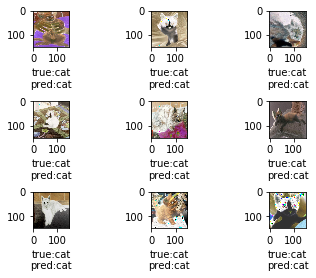

In [51]:
fig, axes = plt.subplots(3,3)
fig.subplots_adjust(hspace=1.5, wspace=0.2)
for i,ax in enumerate(axes.flat):
    ax.imshow(validation[i])
    ax.set_xlabel("true:"+class_names[np.argmax(validation_labels[i])]+'\n'+ "pred:"+class_names[np.argmax(pred[i])])
plt.show()